## ResNet18 + RNN Hybrid Model

Input should remain the same as npy file shape: input_data = (1, 96, 1376)

In [14]:
# Importing needed libraries with pytorch
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import torchvision.models as models
from torchsummary import summary
import tqdm
from torchvision.models import ResNet18_Weights
from torch.utils.data import WeightedRandomSampler

In [9]:
DEVICE = (
    "mps"
    if torch.backends.mps.is_built()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print("Using device:", DEVICE)

# Create a class for hybrid model (ResNet18 + RNN), import model from Torchvision, models. Input size of the model should be the same as spectogram shape (1, 96, 1376)

class ResNetRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(ResNetRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet.fc = nn.Identity()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.to(DEVICE)  # Ensure input is on the same device as the model
        with torch.no_grad():
            x = self.resnet(x)
        x = x.view(x.size(0), -1, x.size(1))  # Reshape to (batch_size, sequence_length, input_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(DEVICE)  # Ensure h0 is on the same device
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

Using device: mps


In [36]:
# Create instance of the model and print summary
model = ResNetRNN(input_size=512, hidden_size=512, num_layers=2, num_classes=8).to(DEVICE)
summary(model, (1, 96, 1376))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 48, 688]           3,136
       BatchNorm2d-2          [-1, 64, 48, 688]             128
              ReLU-3          [-1, 64, 48, 688]               0
         MaxPool2d-4          [-1, 64, 24, 344]               0
            Conv2d-5          [-1, 64, 24, 344]          36,864
       BatchNorm2d-6          [-1, 64, 24, 344]             128
              ReLU-7          [-1, 64, 24, 344]               0
            Conv2d-8          [-1, 64, 24, 344]          36,864
       BatchNorm2d-9          [-1, 64, 24, 344]             128
             ReLU-10          [-1, 64, 24, 344]               0
       BasicBlock-11          [-1, 64, 24, 344]               0
           Conv2d-12          [-1, 64, 24, 344]          36,864
      BatchNorm2d-13          [-1, 64, 24, 344]             128
             ReLU-14          [-1, 64, 

In [3]:

class MelSpectogramDataset(Dataset):
    def __init__(self, data_path, transform=None, max_samples_dict=None):
        """
        Initialize the MelSpectogramDataset class.

        Args:
            data_path (str): Path to the folder containing the mel spectrogram files.
            transform (callable): Optional transform to be applied to the mel spectrogram.
            max_samples_dict (dict): Dictionary specifying the maximum number of samples per genre. 
                                     For example: {'rock': 1000, 'pop': 600}.
        """

        self.data_path = data_path
        self.transform = transform
        self.max_samples_dict = max_samples_dict
        self.genres = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]
        self.file_paths = []
        self.labels = []

        for i, genre in enumerate(self.genres):
            genre_folder = os.path.join(data_path, genre)
            files = [f for f in os.listdir(genre_folder) if f.endswith('.npy')]

            # Check if this genre has a max_samples limit
            if max_samples_dict and genre in max_samples_dict:
                max_samples = max_samples_dict[genre]
                files = np.random.choice(files, size=min(max_samples, len(files)), replace=False).tolist()

            self.file_paths.extend([os.path.join(genre_folder, f) for f in files])
            self.labels.extend([i] * len(files))

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        mel_spectrogram = np.load(self.file_paths[idx])
        label = self.labels[idx]

        if self.transform:
            mel_spectrogram = self.transform(mel_spectrogram)

        return mel_spectrogram, label


from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

In [4]:
def calculate_metrics(y_true, y_pred_probs, num_classes):
    """
    Calculate AUC, precision, recall, and F1 score for multiclass classification.

    Args:
        y_true (array-like): True labels.
        y_pred_probs (array-like): Predicted probabilities or logits.
        num_classes (int): Number of classes in the classification task.

    Returns:
        dict: A dictionary containing AUC, precision, recall, and F1 scores.
    """
    # Convert predicted probabilities to class predictions
    y_pred = y_pred_probs.argmax(axis=1)

    # Calculate metrics
    metrics = {
        "AUC": roc_auc_score(y_true, y_pred_probs, multi_class="ovr", average="macro"),
        "Precision": precision_score(y_true, y_pred, average="macro", zero_division=1),
        "Recall": recall_score(y_true, y_pred, average="macro"),
        "F1 Score": f1_score(y_true, y_pred, average="macro")
    }
    return metrics


from sklearn.metrics import classification_report


def per_class_metrics(y_true, y_pred, num_classes):
    """
    Prints classification metrics for each class.

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        num_classes (int): Number of classes in the classification task.
    """
    report = classification_report(
        y_true,
        y_pred,
        zero_division=1,
        target_names=[f"Class {i}" for i in range(num_classes)]
    )
    print(report)

In [42]:
# Pop and hiphop are overwhealming rest of the classes because of the dataset imbalance
# Let's try to undersample the dataset genres: pop and hiphop and train again.
# Change the max_samples_dict to undersample pop and hiphop genres in the objective and train the model again.


import optuna
from sklearn.model_selection import train_test_split
from torch.utils.data import WeightedRandomSampler


def objective(trial):
    # Hyperparameters to optimize
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    
    # Layers of the RNN to optimize
    num_layers = trial.suggest_int("num_layers", 1, 3)

    # Create a MelSpectogramDataset instance
    """
    Training the model with stratified split, apply weighted random sampler with Optuna.
    """
    # Create dataset instance

    mel_dataset = MelSpectogramDataset(data_path='spectograms_data')

    # Split the dataset into train, validation and test with 90-5-5 split

    # Access file paths and labels
    file_paths = mel_dataset.file_paths
    labels = mel_dataset.labels

    # Split dataset using stratification to train - validate
    train_file_paths, val_file_paths, train_labels, val_labels = train_test_split(
        file_paths, labels, test_size=0.1, random_state=42, stratify=labels
    )

    # Create Datasets for each split
    train_indices = [file_paths.index(path) for path in train_file_paths]
    val_indices = [file_paths.index(path) for path in val_file_paths]

    train_dataset = Subset(mel_dataset, train_indices)
    val_dataset = Subset(mel_dataset, val_indices)

    # Handle imabalanced dataset with WeightedRandomSampler

    # Get train dataset labels
    train_labels = [label for _, label in train_dataset]

    # Get train dataset label count for each class
    class_counts = np.bincount(train_labels)

    # Calculate the class weights
    class_weights = 1.0 / class_counts
    weights = [class_weights[label] for label in train_labels]

    # Create a WeightedRandomSampler
    sampler = WeightedRandomSampler(weights, num_samples=len(train_dataset))

    # Create DataLoader instances
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Set fixed random number of seed
    torch.manual_seed(42)

    # Make use of GPU if available or MPS (Apple) if one is available
    device = (
        "mps"
        if torch.backends.mps.is_built()
        else "cuda"
        if torch.cuda.is_available()
        else "cpu"
    )

    print("Using device:", device)

    # Define the model with dynamic num_filters
    model = ResNetRNN(input_size=512, hidden_size=512, num_layers=num_layers, num_classes=8).to(device)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    num_epochs = 4
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_progress = tqdm.tqdm(train_loader, desc=f"Training Epoch {epoch + 1}", leave=False)

        for mel_spectrogram, label in train_progress:
            mel_spectrogram, label = mel_spectrogram.to(device).float(), label.to(device)
            optimizer.zero_grad()
            output = model(mel_spectrogram.unsqueeze(1))
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            # Update progress bar
            running_loss += loss.item()
            train_progress.set_postfix({"Loss": f"{running_loss / (train_progress.n + 1):.4f}"})

        # Evaluate the CNN model
        model.eval()
        all_labels, all_probs = [], []
        test_progress = tqdm.tqdm(val_loader, desc=f"Testing Epoch {epoch + 1}", leave=False)

        # Use Early Stopping
        with torch.no_grad():
            for mel_spectrogram, label in test_progress:
                mel_spectrogram, label = mel_spectrogram.to(device).float(), label.to(device)
                output = model(mel_spectrogram.unsqueeze(1))
                probabilities = nn.Softmax(dim=1)(output).cpu().numpy()
                all_probs.append(probabilities)
                all_labels.append(label.cpu().numpy())

        # Concatenate all predictions and true labels
        all_labels = np.concatenate(all_labels)
        all_probs = np.concatenate(all_probs)

        # Calculate metrics
        f1 = calculate_metrics(all_labels, all_probs, num_classes=8)["F1 Score"]

        trial.report(f1, epoch)

        # Prune if needed based on the reported F1 score
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        # Optionally, print the F1 score for each epoch
        print(f"Epoch {epoch + 1} - F1 Score: {f1:.4f}")

    # Return the F1 score after the training loop
    return f1

In [43]:
# Optuna study
study_name = "resnet_rnn_hybrid_optimization_v1_weighted_stratified"
# Create a file to save study name and my comments on used dataset and hyperparameters
study_comment = "Full dataset. Optimizing learning rate, batch size. No cross-validation used. 90-10 split for training and validation. Stratified split used. WeightedRandomSampler used for training."
study_comment_file = "study_comment.csv"

# Write new line with study name and comment
with open(study_comment_file, "a") as f:
    f.write(f"\n{study_name},{study_comment}")
# Create an Optuna study
study = optuna.create_study(direction="maximize", storage="sqlite:///db.sqlite3", study_name=study_name,
                            load_if_exists=True)
study.optimize(objective, n_trials=10)

# Best trial
print("Best trial:")
print(f"F1 Score: {study.best_trial.value}")
print(f"Params: {study.best_trial.params}")


[I 2025-01-06 10:37:06,631] Using an existing study with name 'resnet_rnn_hybrid_optimization_v1_weighted_stratified' instead of creating a new one.


Using device: mps


/Users/julia.rozycka/Master/MTG_Jamendo_dataset/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/julia.rozycka/Master/MTG_Jamendo_dataset/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 - F1 Score: 0.2984


Epoch 2 - F1 Score: 0.3075


Epoch 3 - F1 Score: 0.3634


[I 2025-01-06 10:41:00,834] Trial 1 finished with value: 0.35951052781828635 and parameters: {'learning_rate': 5.886952730486881e-05, 'batch_size': 16, 'num_layers': 2}. Best is trial 1 with value: 0.35951052781828635.


Epoch 4 - F1 Score: 0.3595
Using device: mps


/Users/julia.rozycka/Master/MTG_Jamendo_dataset/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/julia.rozycka/Master/MTG_Jamendo_dataset/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 - F1 Score: 0.3026


Epoch 2 - F1 Score: 0.3010


Epoch 3 - F1 Score: 0.3825


[I 2025-01-06 10:44:41,023] Trial 2 finished with value: 0.3708876160592889 and parameters: {'learning_rate': 0.0002097714241764038, 'batch_size': 32, 'num_layers': 2}. Best is trial 2 with value: 0.3708876160592889.


Epoch 4 - F1 Score: 0.3709
Using device: mps


/Users/julia.rozycka/Master/MTG_Jamendo_dataset/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/julia.rozycka/Master/MTG_Jamendo_dataset/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 - F1 Score: 0.3569


Epoch 2 - F1 Score: 0.3343


Epoch 3 - F1 Score: 0.4030


[I 2025-01-06 10:48:29,854] Trial 3 finished with value: 0.3595341632416564 and parameters: {'learning_rate': 0.00049482667470072, 'batch_size': 16, 'num_layers': 2}. Best is trial 2 with value: 0.3708876160592889.


Epoch 4 - F1 Score: 0.3595
Using device: mps


/Users/julia.rozycka/Master/MTG_Jamendo_dataset/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/julia.rozycka/Master/MTG_Jamendo_dataset/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 - F1 Score: 0.2820


Epoch 2 - F1 Score: 0.2647


Epoch 3 - F1 Score: 0.2643


[I 2025-01-06 10:52:06,674] Trial 4 finished with value: 0.29123966226973863 and parameters: {'learning_rate': 1.5721437861490498e-05, 'batch_size': 64, 'num_layers': 1}. Best is trial 2 with value: 0.3708876160592889.


Epoch 4 - F1 Score: 0.2912
Using device: mps


/Users/julia.rozycka/Master/MTG_Jamendo_dataset/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/julia.rozycka/Master/MTG_Jamendo_dataset/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 - F1 Score: 0.2841


Epoch 2 - F1 Score: 0.2808


Epoch 3 - F1 Score: 0.3535


[I 2025-01-06 10:55:41,287] Trial 5 finished with value: 0.3560849133858458 and parameters: {'learning_rate': 0.0005912180701924612, 'batch_size': 64, 'num_layers': 2}. Best is trial 2 with value: 0.3708876160592889.


Epoch 4 - F1 Score: 0.3561
Using device: mps


/Users/julia.rozycka/Master/MTG_Jamendo_dataset/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/julia.rozycka/Master/MTG_Jamendo_dataset/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
[I 2025-01-06 10:56:45,133] Trial 6 pruned.                                     


Using device: mps


/Users/julia.rozycka/Master/MTG_Jamendo_dataset/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/julia.rozycka/Master/MTG_Jamendo_dataset/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 - F1 Score: 0.3043


Epoch 2 - F1 Score: 0.3556


[I 2025-01-06 10:59:26,249] Trial 7 pruned.                                     


Using device: mps


/Users/julia.rozycka/Master/MTG_Jamendo_dataset/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/julia.rozycka/Master/MTG_Jamendo_dataset/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
[I 2025-01-06 11:00:27,511] Trial 8 pruned.                                     
/Users/julia.rozycka/Master/MTG_Jamendo_dataset/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the futur

Using device: mps


[I 2025-01-06 11:01:25,059] Trial 9 pruned.                                     


Using device: mps


/Users/julia.rozycka/Master/MTG_Jamendo_dataset/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/julia.rozycka/Master/MTG_Jamendo_dataset/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
[I 2025-01-06 11:02:23,173] Trial 10 pruned.                                    


Best trial:
F1 Score: 0.3708876160592889
Params: {'learning_rate': 0.0002097714241764038, 'batch_size': 32, 'num_layers': 2}


In [45]:
best_params = study.best_trial.params
model = ResNetRNN(input_size=512, hidden_size=512, num_layers=best_params['num_layers'], num_classes=8).to(DEVICE)
# Prepare data

mel_dataset = MelSpectogramDataset(data_path='spectograms_data')

# Split the dataset into train, validation and test with 90-5-5 split
# Access file paths and labels
file_paths = mel_dataset.file_paths
labels = mel_dataset.labels

# Split dataset using stratification
train_file_paths, temp_file_paths, train_labels, temp_labels = train_test_split(
    file_paths, labels, test_size=0.1, random_state=42, stratify=labels
)

val_file_paths, test_file_paths, val_labels, test_labels = train_test_split(
    temp_file_paths, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

# Create Datasets for each split
train_indices = [file_paths.index(path) for path in train_file_paths]
val_indices = [file_paths.index(path) for path in val_file_paths]
test_indices = [file_paths.index(path) for path in test_file_paths]

train_dataset = Subset(mel_dataset, train_indices)
val_dataset = Subset(mel_dataset, val_indices)
test_dataset = Subset(mel_dataset, test_indices)

# Handle imabalanced dataset with WeightedRandomSampler

# Get train dataset labels
train_labels = [label for _, label in train_dataset]

# Get train dataset label count for each class
class_counts = np.bincount(train_labels)

# Calculate the class weights
class_weights = 1.0 / class_counts
weights = [class_weights[label] for label in train_labels]

# Create a WeightedRandomSampler
sampler = WeightedRandomSampler(weights, num_samples=len(train_dataset))

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'])

# Model

# Define the model with dynamic num_filters
model = model.to("mps")

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['learning_rate'])
# Set fixed random number of seed
torch.manual_seed(42)

# Plain training loop without early stopping
num_epochs = 8

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_progress = tqdm.tqdm(train_loader, desc=f"Training Epoch {epoch + 1}", leave=False)

    for mel_spectrogram, label in train_progress:
        mel_spectrogram, label = mel_spectrogram.to("mps").float(), label.to("mps")
        optimizer.zero_grad()
        output = model(mel_spectrogram.unsqueeze(1))
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        # Update progress bar
        running_loss += loss.item()
        train_progress.set_postfix({"Loss": f"{running_loss / (train_progress.n + 1):.4f}"})

    # Evaluate the CNN model on the validation set
    model.eval()
    correct, total = 0, 0
    all_labels, all_probs = [], []
    all_labels_per_class, all_probs_per_class = [], []
    test_progress = tqdm.tqdm(val_loader, desc=f"Testing Epoch {epoch + 1}", leave=False)

    with torch.no_grad():
        for mel_spectrogram, label in test_progress:
            mel_spectrogram, label = mel_spectrogram.to("mps").float(), label.to("mps")
            output = model(mel_spectrogram.unsqueeze(1))
            probabilities = nn.Softmax(dim=1)(output).cpu().numpy()
            all_probs.append(probabilities)
            all_labels.append(label.cpu().numpy())
            all_labels_per_class.extend(label.cpu().numpy())
            all_probs_per_class.extend(output.cpu().numpy())
            _, predicted = torch.max(output.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()

            # Calculate the loss
            loss = criterion(output, label)
            test_progress.set_postfix({"Loss": f"{loss.item():.4f}"})

    # Concatenate all predictions and true labels
    all_labels = np.concatenate(all_labels)
    all_probs = np.concatenate(all_probs)

    all_labels_per_class = np.array(all_labels_per_class)
    all_probs_per_class = np.array(all_probs_per_class)
    y_pred = all_probs_per_class.argmax(axis=1)

    # Per-class metrics
    print(f"Epoch {epoch + 1}:")
    print("PER CLASS METRICS")
    per_class_metrics(all_labels, y_pred, num_classes=8)
    print("OVERALL METRICS")

    # Calculate metrics
    metrics = calculate_metrics(all_labels, all_probs, num_classes=8)
    print(f"Epoch {epoch + 1}: Accuracy: {100 * correct / total:.2f}% | Metrics: {metrics}")

# Save this model
torch.save(model.state_dict(), "models/resnet_model_v1_weighted.pth")
# Evaluate the model on the test set

/Users/julia.rozycka/Master/MTG_Jamendo_dataset/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/julia.rozycka/Master/MTG_Jamendo_dataset/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1:
PER CLASS METRICS
              precision    recall  f1-score   support

     Class 0       0.53      0.32      0.40       260
     Class 1       0.31      0.80      0.44        44
     Class 2       0.21      0.19      0.20        53
     Class 3       0.43      0.23      0.30       173
     Class 4       0.41      0.62      0.49        73
     Class 5       0.16      0.38      0.23        21
     Class 6       0.29      0.57      0.38         7
     Class 7       0.39      0.60      0.47        90

    accuracy                           0.39       721
   macro avg       0.34      0.46      0.36       721
weighted avg       0.43      0.39      0.38       721

OVERALL METRICS
Epoch 1: Accuracy: 38.56% | Metrics: {'AUC': 0.835968880268581, 'Precision': 0.3407109496513192, 'Recall': 0.4622021743156538, 'F1 Score': 0.3632909215872916}


Epoch 2:
PER CLASS METRICS
              precision    recall  f1-score   support

     Class 0       0.53      0.32      0.40       260
     Class 1       0.30      0.86      0.45        44
     Class 2       0.16      0.13      0.15        53
     Class 3       0.52      0.23      0.31       173
     Class 4       0.39      0.48      0.43        73
     Class 5       0.14      0.62      0.23        21
     Class 6       0.17      1.00      0.29         7
     Class 7       0.45      0.50      0.48        90

    accuracy                           0.37       721
   macro avg       0.33      0.52      0.34       721
weighted avg       0.45      0.37      0.37       721

OVERALL METRICS
Epoch 2: Accuracy: 36.89% | Metrics: {'AUC': 0.8342731314890198, 'Precision': 0.33400333133259874, 'Recall': 0.516878706321599, 'F1 Score': 0.34078491924206356}


Epoch 3:
PER CLASS METRICS
              precision    recall  f1-score   support

     Class 0       0.56      0.38      0.45       260
     Class 1       0.41      0.52      0.46        44
     Class 2       0.14      0.19      0.16        53
     Class 3       0.49      0.39      0.43       173
     Class 4       0.42      0.53      0.47        73
     Class 5       0.17      0.43      0.24        21
     Class 6       0.11      1.00      0.19         7
     Class 7       0.54      0.41      0.47        90

    accuracy                           0.40       721
   macro avg       0.35      0.48      0.36       721
weighted avg       0.47      0.40      0.42       721

OVERALL METRICS
Epoch 3: Accuracy: 40.36% | Metrics: {'AUC': 0.839592192708053, 'Precision': 0.3543950379664194, 'Recall': 0.48167351259984337, 'F1 Score': 0.3599419726061386}


Epoch 4:
PER CLASS METRICS
              precision    recall  f1-score   support

     Class 0       0.51      0.10      0.17       260
     Class 1       0.33      0.75      0.46        44
     Class 2       0.18      0.26      0.22        53
     Class 3       0.50      0.13      0.21       173
     Class 4       0.40      0.58      0.47        73
     Class 5       0.08      0.76      0.15        21
     Class 6       0.19      0.86      0.31         7
     Class 7       0.41      0.53      0.47        90

    accuracy                           0.29       721
   macro avg       0.32      0.50      0.31       721
weighted avg       0.43      0.29      0.27       721

OVERALL METRICS
Epoch 4: Accuracy: 28.99% | Metrics: {'AUC': 0.8292845913252461, 'Precision': 0.3249643577760081, 'Recall': 0.4973335615319212, 'F1 Score': 0.3059713611121031}


Epoch 5:
PER CLASS METRICS
              precision    recall  f1-score   support

     Class 0       0.65      0.15      0.25       260
     Class 1       0.45      0.39      0.41        44
     Class 2       0.16      0.51      0.24        53
     Class 3       0.50      0.29      0.37       173
     Class 4       0.38      0.66      0.48        73
     Class 5       0.35      0.29      0.32        21
     Class 6       0.15      1.00      0.25         7
     Class 7       0.39      0.68      0.49        90

    accuracy                           0.36       721
   macro avg       0.38      0.49      0.35       721
weighted avg       0.49      0.36      0.34       721

OVERALL METRICS
Epoch 5: Accuracy: 35.51% | Metrics: {'AUC': 0.8386257494374039, 'Precision': 0.37691366196058124, 'Recall': 0.4949609254477262, 'F1 Score': 0.35175802375161425}


Epoch 6:
PER CLASS METRICS
              precision    recall  f1-score   support

     Class 0       0.67      0.07      0.13       260
     Class 1       0.28      0.84      0.42        44
     Class 2       0.14      0.32      0.20        53
     Class 3       0.48      0.16      0.24       173
     Class 4       0.39      0.71      0.51        73
     Class 5       0.19      0.48      0.27        21
     Class 6       0.18      1.00      0.31         7
     Class 7       0.39      0.69      0.50        90

    accuracy                           0.32       721
   macro avg       0.34      0.53      0.32       721
weighted avg       0.48      0.32      0.27       721

OVERALL METRICS
Epoch 6: Accuracy: 32.04% | Metrics: {'AUC': 0.8396809033171454, 'Precision': 0.34061036453789534, 'Recall': 0.5337690525382879, 'F1 Score': 0.32100394997666254}


Epoch 7:
PER CLASS METRICS
              precision    recall  f1-score   support

     Class 0       0.61      0.27      0.38       260
     Class 1       0.36      0.86      0.50        44
     Class 2       0.16      0.36      0.22        53
     Class 3       0.49      0.10      0.16       173
     Class 4       0.42      0.70      0.53        73
     Class 5       0.16      0.57      0.25        21
     Class 6       0.25      0.57      0.35         7
     Class 7       0.41      0.60      0.48        90

    accuracy                           0.37       721
   macro avg       0.36      0.50      0.36       721
weighted avg       0.47      0.37      0.35       721

OVERALL METRICS
Epoch 7: Accuracy: 36.89% | Metrics: {'AUC': 0.8367333599618335, 'Precision': 0.35594848534508905, 'Recall': 0.504369628568528, 'F1 Score': 0.35935803112578923}


Epoch 8:
PER CLASS METRICS
              precision    recall  f1-score   support

     Class 0       0.65      0.13      0.21       260
     Class 1       0.35      0.80      0.49        44
     Class 2       0.16      0.34      0.22        53
     Class 3       0.48      0.17      0.25       173
     Class 4       0.36      0.73      0.48        73
     Class 5       0.12      0.67      0.20        21
     Class 6       0.33      0.43      0.38         7
     Class 7       0.44      0.60      0.51        90

    accuracy                           0.33       721
   macro avg       0.36      0.48      0.34       721
weighted avg       0.48      0.33      0.30       721

OVERALL METRICS
Epoch 8: Accuracy: 33.29% | Metrics: {'AUC': 0.8393097833559946, 'Precision': 0.36102559564424425, 'Recall': 0.48208452012621283, 'F1 Score': 0.3422794918670221}


In [46]:
# Evaluate the model on the test set
test_model = ResNetRNN(input_size=512, hidden_size=512, num_layers=best_params['num_layers'], num_classes=8).to(DEVICE)

test_model = test_model.to("mps")

# Load the model weights
test_model.load_state_dict(torch.load("models/resnet_model_v1_weighted.pth", weights_only=True))

# Create a DataLoader instance for the test set
# test_loader = DataLoader(test_dataset, batch_size=32)

test_model.eval()

with torch.no_grad():
    correct, total = 0, 0
    all_labels, all_probs = [], []
    all_labels_per_class, all_probs_per_class = [], []
    test_progress = tqdm.tqdm(test_loader, desc="Testing", leave=False)

    for mel_spectrogram, label in test_progress:
        mel_spectrogram, label = mel_spectrogram.to("mps").float(), label.to("mps")
        output = test_model(mel_spectrogram.unsqueeze(1))
        probabilities = nn.Softmax(dim=1)(output).cpu().numpy()
        all_probs.append(probabilities)
        all_labels.append(label.cpu().numpy())
        all_labels_per_class.extend(label.cpu().numpy())
        all_probs_per_class.extend(output.cpu().numpy())
        _, predicted = torch.max(output.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

        # Calculate the loss
        loss = criterion(output, label)
        test_progress.set_postfix({"Loss": f"{loss.item():.4f}"})

    # Concatenate all predictions and true labels
    all_labels = np.concatenate(all_labels)
    all_probs = np.concatenate(all_probs)

    all_labels_per_class = np.array(all_labels_per_class)
    all_probs_per_class = np.array(all_probs_per_class)
    y_pred = all_probs_per_class.argmax(axis=1)

    # Per-class metrics
    print("PER CLASS METRICS")
    per_class_metrics(all_labels, y_pred, num_classes=8)

    # Calculate metrics
    metrics = calculate_metrics(all_labels, all_probs, num_classes=8)
    print("OVERALL METRICS")

    print(f"Accuracy: {100 * correct / total:.2f}% | Metrics: {metrics}")

/Users/julia.rozycka/Master/MTG_Jamendo_dataset/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/julia.rozycka/Master/MTG_Jamendo_dataset/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
                                                                     

PER CLASS METRICS
              precision    recall  f1-score   support

     Class 0       0.61      0.13      0.22       260
     Class 1       0.38      0.84      0.52        45
     Class 2       0.18      0.36      0.24        53
     Class 3       0.65      0.21      0.32       173
     Class 4       0.38      0.78      0.51        73
     Class 5       0.14      0.68      0.23        22
     Class 6       0.13      0.33      0.19         6
     Class 7       0.46      0.66      0.54        90

    accuracy                           0.36       722
   macro avg       0.37      0.50      0.35       722
weighted avg       0.52      0.36      0.33       722

OVERALL METRICS
Accuracy: 36.15% | Metrics: {'AUC': 0.822694831223635, 'Precision': 0.3669211446348545, 'Recall': 0.49964648364524844, 'F1 Score': 0.34607282020990704}


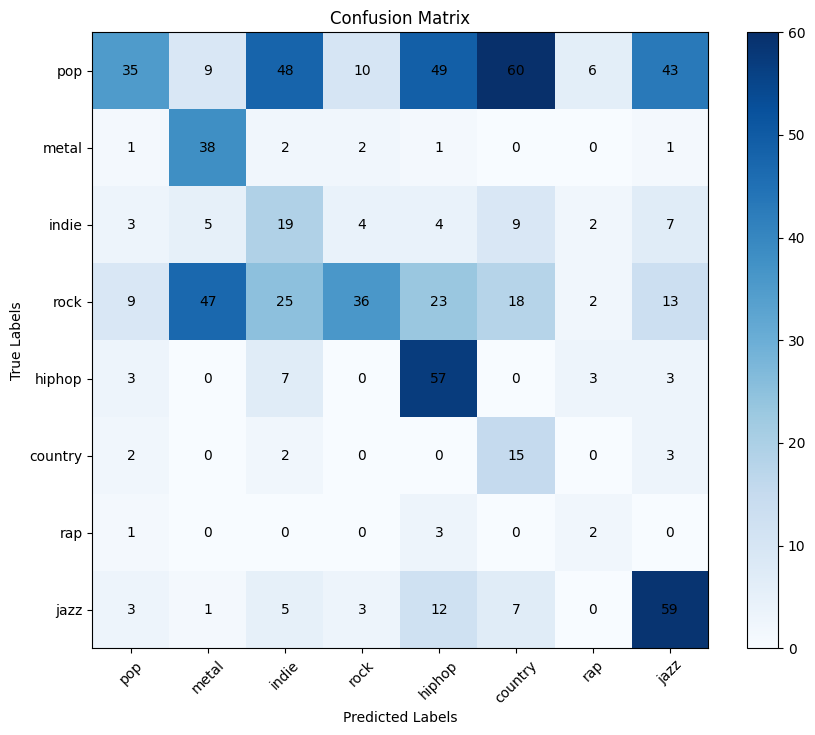

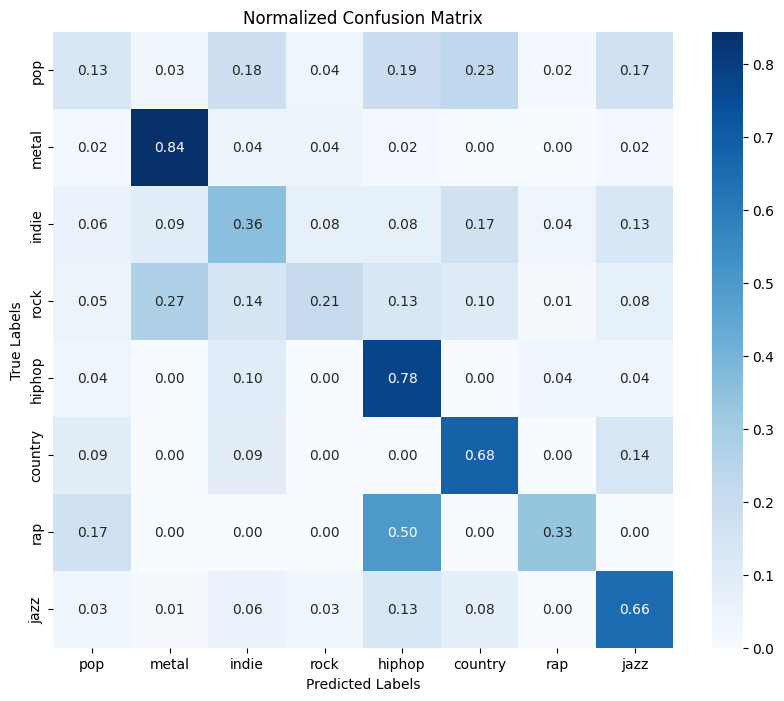

In [47]:
# Plot the confusion matrix with annotations on test set
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, y_pred)

# Plot the confusion matrix with annotations
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, cmap="Blues")
plt.colorbar()
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(range(8), mel_dataset.genres, rotation=45)
plt.yticks(range(8), mel_dataset.genres)
for i in range(8):
    for j in range(8):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="black")
plt.show()
# Now plot the normalized confusion matrix
import seaborn as sns

# Normalize the confusion matrix
conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_norm, cmap="Blues", annot=True, fmt=".2f", xticklabels=mel_dataset.genres,
            yticklabels=mel_dataset.genres)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

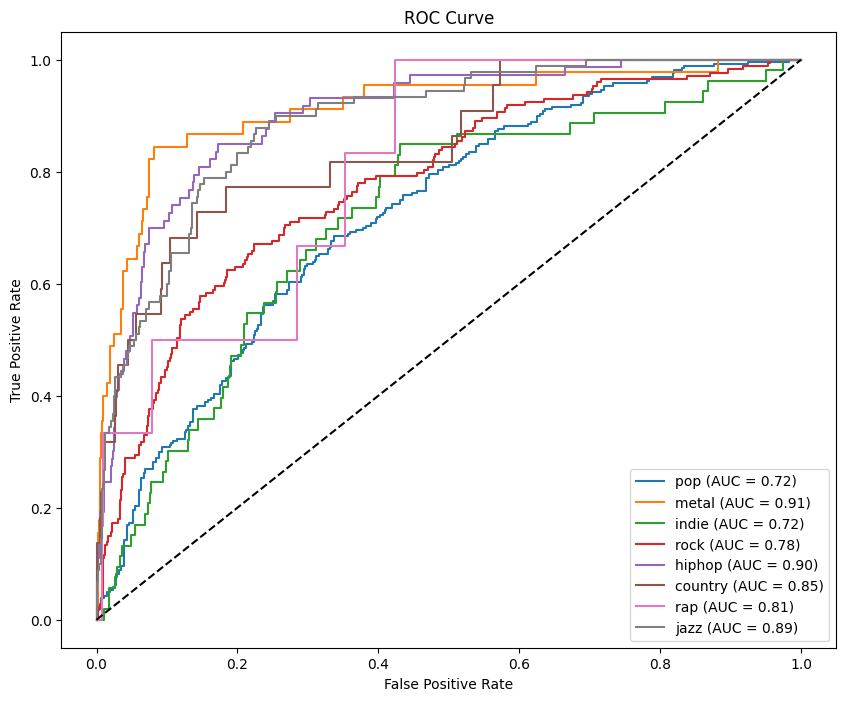

In [48]:
# Plot ROC curve
from sklearn.metrics import roc_curve

# Get the true positive rate and false positive rate
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(8):
    fpr[i], tpr[i], _ = roc_curve((all_labels == i).astype(int), all_probs[:, i])
    roc_auc[i] = roc_auc_score((all_labels == i).astype(int), all_probs[:, i])

# Plot the ROC curve
plt.figure(figsize=(10, 8))
for i in range(8):
    plt.plot(fpr[i], tpr[i], label=f"{mel_dataset.genres[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
# Add legend
plt.legend()
plt.show()

In [ ]:
# Worse with pop but better with f.ex. rap, metal, hiphop

In [5]:
# ResNet18 + LSTM Hybrid Model
# Create a class for hybrid model (ResNet18 + LSTM), import model from Torchvision, models. Input size of the model should be the same as spectogram shape (1, 96, 1376)    

class ResNetLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(ResNetLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.resnet = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet.fc = nn.Identity()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        """
        Forward pass for ResNet18 + LSTM hybrid.
    
        Args:
            x (torch.Tensor): Input tensor of shape (Batch, Channels, Height, Width).
    
        Returns:
            torch.Tensor: Output tensor of shape (Batch, num_classes).
        """

        # Ensure input is 4D (Batch, Channels, Height, Width)
        if x.dim() == 3:  # If input is (Batch, Height, Width)
            x = x.unsqueeze(1)  # Add channel dimension
                
        # Pass input through ResNet18 layers
        features = self.resnet.conv1(x)
        features = self.resnet.bn1(features)
        features = self.resnet.relu(features)
        features = self.resnet.maxpool(features)
    
        features = self.resnet.layer1(features)
        features = self.resnet.layer2(features)
        features = self.resnet.layer3(features)
        features = self.resnet.layer4(features)
            
        # Shape after ResNet: (Batch, Channels, Height, Width)
        batch_size, channels, height, width = features.size()
    
        # Reshape features for LSTM: (Batch, Time, Features)
        # Time = Width, Features = Channels * Height
        rnn_input = features.permute(0, 3, 1, 2).reshape(batch_size, width, channels * height)
            
        # Pass through LSTM
        lstm_out, _ = self.lstm(rnn_input)  # LSTM outputs all timesteps
            
        # Use the last timestep's output
        final_output = self.fc(lstm_out[:, -1, :])  # Shape: (Batch, num_classes)
    
        return final_output

        

In [103]:
# Instantiate the model
input_size = 512 * 3# Channels * Height from ResNet output
hidden_size = 256
num_layers = 2
num_classes = 8
batch_size = 32

model = ResNetLSTM(input_size, hidden_size, num_layers, num_classes)

# Test the model
test_input = torch.randn(batch_size, 1, 96, 1376) # Batch size 2, 1 channel, 96x1376 input
output = model(test_input)
print(f"Output shape: {output.shape}")  # Should be (Batch, num_classes)


Output shape: torch.Size([32, 8])


In [104]:
model.eval()

ResNetLSTM(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [105]:
# Pop and hiphop are overwhealming rest of the classes because of the dataset imbalance
# Let's try to undersample the dataset genres: pop and hiphop and train again.
# Change the max_samples_dict to undersample pop and hiphop genres in the objective and train the model again.


import optuna
from sklearn.model_selection import train_test_split
from torch.utils.data import WeightedRandomSampler


def objective(trial):
    # Hyperparameters to optimize
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    # Layers of the RNN to optimize
    num_layers = trial.suggest_int("num_layers", 1, 3)

    # Create a MelSpectogramDataset instance
    """
    Training the model with stratified split, apply weighted random sampler with Optuna.
    """
    # Create dataset instance

    mel_dataset = MelSpectogramDataset(data_path='spectograms_data')

    # Split the dataset into train, validation and test with 90-5-5 split

    # Access file paths and labels
    file_paths = mel_dataset.file_paths
    labels = mel_dataset.labels

    # Split dataset using stratification to train - validate
    train_file_paths, val_file_paths, train_labels, val_labels = train_test_split(
        file_paths, labels, test_size=0.1, random_state=42, stratify=labels
    )

    # Create Datasets for each split
    train_indices = [file_paths.index(path) for path in train_file_paths]
    val_indices = [file_paths.index(path) for path in val_file_paths]

    train_dataset = Subset(mel_dataset, train_indices)
    val_dataset = Subset(mel_dataset, val_indices)

    # Handle imabalanced dataset with WeightedRandomSampler

    # Get train dataset labels
    train_labels = [label for _, label in train_dataset]

    # Get train dataset label count for each class
    class_counts = np.bincount(train_labels)

    # Calculate the class weights
    class_weights = 1.0 / class_counts
    weights = [class_weights[label] for label in train_labels]

    # Create a WeightedRandomSampler
    sampler = WeightedRandomSampler(weights, num_samples=len(train_dataset))

    # Create DataLoader instances
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Set fixed random number of seed
    torch.manual_seed(42)

    # Make use of GPU if available or MPS (Apple) if one is available
    device = (
        "mps"
        if torch.backends.mps.is_built()
        else "cuda"
        if torch.cuda.is_available()
        else "cpu"
    )

    # Define the model with dynamic num_filters
    model = ResNetLSTM(input_size=512 * 3, hidden_size=512, num_layers=num_layers, num_classes=8).to(device)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    num_epochs = 4
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_progress = tqdm.tqdm(train_loader, desc=f"Training Epoch {epoch + 1}", leave=False)

        for mel_spectrogram, label in train_progress:
            mel_spectrogram, label = mel_spectrogram.to(device).float(), label.to(device)
            optimizer.zero_grad()
            output = model(mel_spectrogram.unsqueeze(1))
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            # Update progress bar
            running_loss += loss.item()
            train_progress.set_postfix({"Loss": f"{running_loss / (train_progress.n + 1):.4f}"})

        # Evaluate the CNN model
        model.eval()
        all_labels, all_probs = [], []
        test_progress = tqdm.tqdm(val_loader, desc=f"Testing Epoch {epoch + 1}", leave=False)

        # Use Early Stopping
        with torch.no_grad():
            for mel_spectrogram, label in test_progress:
                mel_spectrogram, label = mel_spectrogram.to(device).float(), label.to(device)
                output = model(mel_spectrogram.unsqueeze(1))
                probabilities = nn.Softmax(dim=1)(output).cpu().numpy()
                all_probs.append(probabilities)
                all_labels.append(label.cpu().numpy())

        # Concatenate all predictions and true labels
        all_labels = np.concatenate(all_labels)
        all_probs = np.concatenate(all_probs)

        # Calculate metrics
        f1 = calculate_metrics(all_labels, all_probs, num_classes=8)["F1 Score"]

        trial.report(f1, epoch)

        # Prune if needed based on the reported F1 score
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        # Optionally, print the F1 score for each epoch
        print(f"Epoch {epoch + 1} - F1 Score: {f1:.4f}")

    # Return the F1 score after the training loop
    return f1


In [106]:
# Optuna study
study_name = "resnet_lstm_hybrid_optimization_v1_weighted_stratified"
# Create a file to save study name and my comments on used dataset and hyperparameters
study_comment = "Full dataset. Optimizing learning rate, batch size. No cross-validation used. 90-10 split for training and validation. Stratified split used. WeightedRandomSampler used for training. LSTM+ResNet model."
study_comment_file = "study_comment.csv"

# Write new line with study name and comment
with open(study_comment_file, "a") as f:
    f.write(f"\n{study_name},{study_comment}")
# Create an Optuna study
study = optuna.create_study(direction="maximize", storage="sqlite:///db.sqlite3", study_name=study_name,
                            load_if_exists=True)
study.optimize(objective, n_trials=15)

[I 2025-01-06 14:23:37,992] Using an existing study with name 'resnet_lstm_hybrid_optimization_v1_weighted_stratified' instead of creating a new one.


Epoch 1 - F1 Score: 0.2934


Epoch 2 - F1 Score: 0.3390


Epoch 3 - F1 Score: 0.3243


[I 2025-01-06 14:34:46,824] Trial 4 finished with value: 0.2985889334802859 and parameters: {'learning_rate': 0.0005747574885926606, 'batch_size': 64, 'num_layers': 1}. Best is trial 4 with value: 0.2985889334802859.


Epoch 4 - F1 Score: 0.2986


Epoch 1 - F1 Score: 0.2638


Epoch 2 - F1 Score: 0.2986


Epoch 3 - F1 Score: 0.3315


[I 2025-01-06 14:46:04,111] Trial 5 finished with value: 0.3333054305283263 and parameters: {'learning_rate': 0.000665222112441532, 'batch_size': 64, 'num_layers': 3}. Best is trial 5 with value: 0.3333054305283263.


Epoch 4 - F1 Score: 0.3333


Epoch 1 - F1 Score: 0.3102


Epoch 2 - F1 Score: 0.3630


Epoch 3 - F1 Score: 0.3596


[I 2025-01-06 14:57:31,626] Trial 6 finished with value: 0.3895306997319654 and parameters: {'learning_rate': 0.00020240510503225724, 'batch_size': 32, 'num_layers': 3}. Best is trial 6 with value: 0.3895306997319654.


Epoch 4 - F1 Score: 0.3895


Epoch 1 - F1 Score: 0.1770


Epoch 2 - F1 Score: 0.2389


Epoch 3 - F1 Score: 0.2810


[I 2025-01-06 15:08:53,399] Trial 7 finished with value: 0.28088860765460855 and parameters: {'learning_rate': 0.0007370583840907838, 'batch_size': 32, 'num_layers': 3}. Best is trial 6 with value: 0.3895306997319654.


Epoch 4 - F1 Score: 0.2809


Epoch 1 - F1 Score: 0.3461


Epoch 2 - F1 Score: 0.4067


Epoch 3 - F1 Score: 0.3961


[I 2025-01-06 15:19:56,531] Trial 8 finished with value: 0.3886874944034447 and parameters: {'learning_rate': 0.00011416631767017522, 'batch_size': 32, 'num_layers': 1}. Best is trial 6 with value: 0.3895306997319654.


Epoch 4 - F1 Score: 0.3887


[I 2025-01-06 15:22:51,169] Trial 9 pruned.                                     


Epoch 1 - F1 Score: 0.3463


Epoch 2 - F1 Score: 0.3468


Epoch 3 - F1 Score: 0.3769


[I 2025-01-06 15:34:21,839] Trial 10 finished with value: 0.36821754251747096 and parameters: {'learning_rate': 0.0003232314565496607, 'batch_size': 64, 'num_layers': 3}. Best is trial 6 with value: 0.3895306997319654.


Epoch 4 - F1 Score: 0.3682


[I 2025-01-06 15:37:23,473] Trial 11 pruned.                                    


Epoch 1 - F1 Score: 0.3669


Epoch 2 - F1 Score: 0.3246


Epoch 3 - F1 Score: 0.4029


[I 2025-01-06 15:49:04,614] Trial 12 finished with value: 0.39167332355401563 and parameters: {'learning_rate': 0.00014847222161310005, 'batch_size': 16, 'num_layers': 3}. Best is trial 12 with value: 0.39167332355401563.


Epoch 4 - F1 Score: 0.3917


[I 2025-01-06 15:52:07,433] Trial 13 pruned.                                    


Epoch 1 - F1 Score: 0.3682


Epoch 2 - F1 Score: 0.4345


Epoch 3 - F1 Score: 0.3992


[I 2025-01-06 16:03:49,361] Trial 14 finished with value: 0.39585016001174733 and parameters: {'learning_rate': 1.7813052916014896e-05, 'batch_size': 16, 'num_layers': 2}. Best is trial 14 with value: 0.39585016001174733.


Epoch 4 - F1 Score: 0.3959


Epoch 1 - F1 Score: 0.3562


Epoch 2 - F1 Score: 0.4085


Epoch 3 - F1 Score: 0.4371


[I 2025-01-06 16:15:28,316] Trial 15 finished with value: 0.45247498914693296 and parameters: {'learning_rate': 1.8529931417413163e-05, 'batch_size': 16, 'num_layers': 2}. Best is trial 15 with value: 0.45247498914693296.


Epoch 4 - F1 Score: 0.4525


Epoch 1 - F1 Score: 0.3493


Epoch 2 - F1 Score: 0.4077


Epoch 3 - F1 Score: 0.4188


[I 2025-01-06 16:26:52,496] Trial 16 finished with value: 0.42009676546125596 and parameters: {'learning_rate': 1.5251443301532725e-05, 'batch_size': 16, 'num_layers': 2}. Best is trial 15 with value: 0.45247498914693296.


Epoch 4 - F1 Score: 0.4201


Epoch 1 - F1 Score: 0.3572


Epoch 2 - F1 Score: 0.4231


Epoch 3 - F1 Score: 0.4121


[I 2025-01-06 16:38:17,142] Trial 17 finished with value: 0.43337912280258384 and parameters: {'learning_rate': 1.3600018514712059e-05, 'batch_size': 16, 'num_layers': 2}. Best is trial 15 with value: 0.45247498914693296.


Epoch 4 - F1 Score: 0.4334


Epoch 1 - F1 Score: 0.3856


Epoch 2 - F1 Score: 0.4185


Epoch 3 - F1 Score: 0.4250


[I 2025-01-06 16:49:43,656] Trial 18 finished with value: 0.4208869151633515 and parameters: {'learning_rate': 3.665815820490302e-05, 'batch_size': 16, 'num_layers': 2}. Best is trial 15 with value: 0.45247498914693296.


Epoch 4 - F1 Score: 0.4209


In [15]:
# Best trial
# print("Best trial:")
# print(f"F1 Score: {study.best_trial.value}")
# print(f"Params: {study.best_trial.params}")
# 
# best_params = study.best_trial.params
model = ResNetLSTM(input_size=512 * 3, hidden_size=512, num_layers=best_params['num_layers'], num_classes=8).to(DEVICE)
# Prepare data

mel_dataset = MelSpectogramDataset(data_path='spectograms_data')

# Split the dataset into train, validation and test with 90-5-5 split
# Access file paths and labels
file_paths = mel_dataset.file_paths
labels = mel_dataset.labels

# Split dataset using stratification
train_file_paths, temp_file_paths, train_labels, temp_labels = train_test_split(
    file_paths, labels, test_size=0.1, random_state=42, stratify=labels
)

val_file_paths, test_file_paths, val_labels, test_labels = train_test_split(
    temp_file_paths, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

# Create Datasets for each split
train_indices = [file_paths.index(path) for path in train_file_paths]
val_indices = [file_paths.index(path) for path in val_file_paths]
test_indices = [file_paths.index(path) for path in test_file_paths]

train_dataset = Subset(mel_dataset, train_indices)
val_dataset = Subset(mel_dataset, val_indices)
test_dataset = Subset(mel_dataset, test_indices)

# Handle imabalanced dataset with WeightedRandomSampler

# Get train dataset labels
train_labels = [label for _, label in train_dataset]

# Get train dataset label count for each class
class_counts = np.bincount(train_labels)

# Calculate the class weights
class_weights = 1.0 / class_counts
weights = [class_weights[label] for label in train_labels]

# Create a WeightedRandomSampler
sampler = WeightedRandomSampler(weights, num_samples=len(train_dataset))

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'])

In [ ]:
# Model

# Define the model with dynamic num_filters
model = model.to("mps")

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['learning_rate'])
# Set fixed random number of seed
torch.manual_seed(42)

# Plain training loop without early stopping
num_epochs = 8

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_progress = tqdm.tqdm(train_loader, desc=f"Training Epoch {epoch + 1}", leave=False)

    for mel_spectrogram, label in train_progress:
        mel_spectrogram, label = mel_spectrogram.to("mps").float(), label.to("mps")
        optimizer.zero_grad()
        output = model(mel_spectrogram.unsqueeze(1))
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        # Update progress bar
        running_loss += loss.item()
        train_progress.set_postfix({"Loss": f"{running_loss / (train_progress.n + 1):.4f}"})

    # Evaluate the CNN model on the validation set
    model.eval()
    correct, total = 0, 0
    all_labels, all_probs = [], []
    all_labels_per_class, all_probs_per_class = [], []
    test_progress = tqdm.tqdm(val_loader, desc=f"Testing Epoch {epoch + 1}", leave=False)

    with torch.no_grad():
        for mel_spectrogram, label in test_progress:
            mel_spectrogram, label = mel_spectrogram.to("mps").float(), label.to("mps")
            output = model(mel_spectrogram.unsqueeze(1))
            probabilities = nn.Softmax(dim=1)(output).cpu().numpy()
            all_probs.append(probabilities)
            all_labels.append(label.cpu().numpy())
            all_labels_per_class.extend(label.cpu().numpy())
            all_probs_per_class.extend(output.cpu().numpy())
            _, predicted = torch.max(output.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()

            # Calculate the loss
            loss = criterion(output, label)
            test_progress.set_postfix({"Loss": f"{loss.item():.4f}"})

    # Concatenate all predictions and true labels
    all_labels = np.concatenate(all_labels)
    all_probs = np.concatenate(all_probs)

    all_labels_per_class = np.array(all_labels_per_class)
    all_probs_per_class = np.array(all_probs_per_class)
    y_pred = all_probs_per_class.argmax(axis=1)

    # Per-class metrics
    print(f"Epoch {epoch + 1}:")
    print("PER CLASS METRICS")
    per_class_metrics(all_labels, y_pred, num_classes=8)
    print("OVERALL METRICS")

    # Calculate metrics
    metrics = calculate_metrics(all_labels, all_probs, num_classes=8)
    print(f"Epoch {epoch + 1}: Accuracy: {100 * correct / total:.2f}% | Metrics: {metrics}")

# Save this model
torch.save(model.state_dict(), "models/resnet_lstm_model_v1_weighted.pth")
# Params: {'learning_rate': 1.8529931417413163e-05, 'batch_size': 16, 'num_layers': 2}

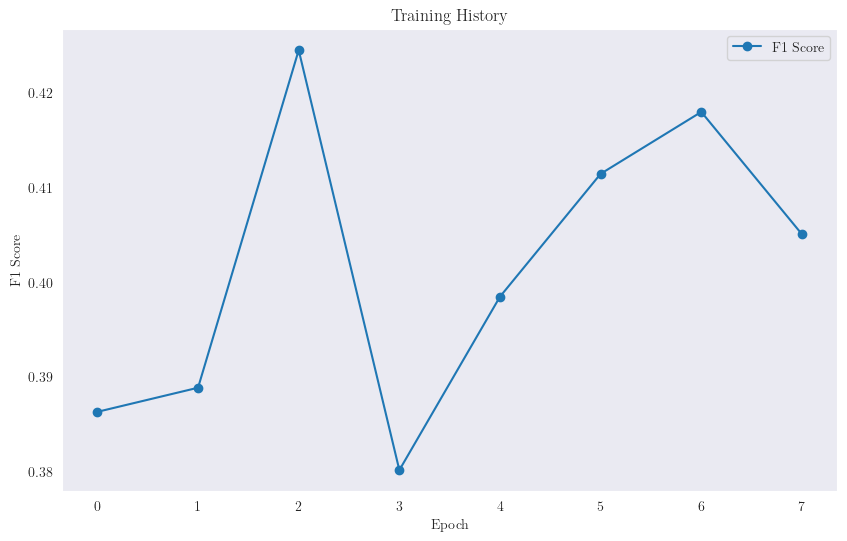

In [16]:
# Plot training history with amtplotlib, use LateX font for better visualization
# Load the model weights
f1_values = [0.3862807751455983, 0.38883032407612794, 0.42452064798923006, 0.38011824897377877, 0.3984572420100985, 0.4114444715334195, 0.4179873479786368, 0.4050534271769628]

# Use LaTeX font
plt.rc("text", usetex=True)
plt.rc("font", family="serif")

# Plot the training history
plt.figure(figsize=(10, 6))
plt.plot(f1_values, label="F1 Score", marker="o")
plt.title("Training History")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()
plt.grid()
plt.show()


PER CLASS METRICS
              precision    recall  f1-score   support

     Class 0       0.61      0.44      0.51       260
     Class 1       0.58      0.56      0.57        45
     Class 2       0.13      0.11      0.12        53
     Class 3       0.52      0.47      0.49       173
     Class 4       0.62      0.62      0.62        73
     Class 5       0.29      0.32      0.30        22
     Class 6       1.00      0.00      0.00         6
     Class 7       0.38      0.80      0.51        90

    accuracy                           0.49       722
   macro avg       0.52      0.41      0.39       722
weighted avg       0.52      0.49      0.48       722

OVERALL METRICS
Accuracy: 48.61% | Metrics: {'AUC': 0.8370847160466971, 'Precision': 0.5155917263505125, 'Recall': 0.4144791568549332, 'F1 Score': 0.39105504758314613}


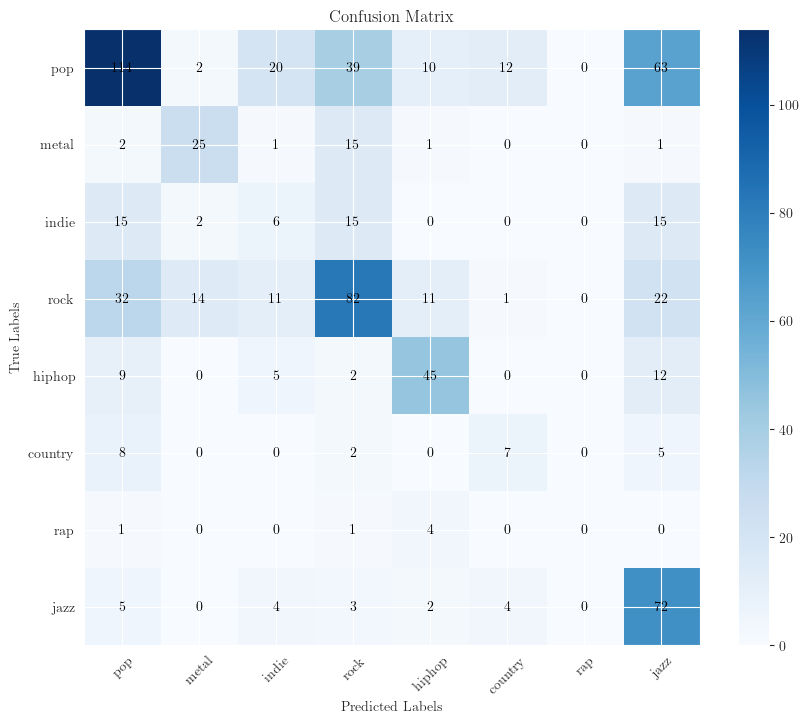

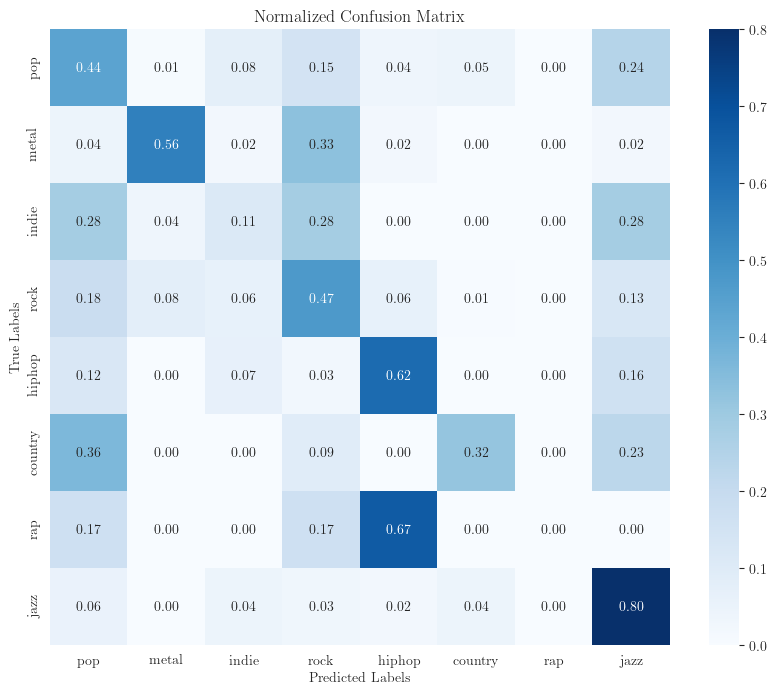

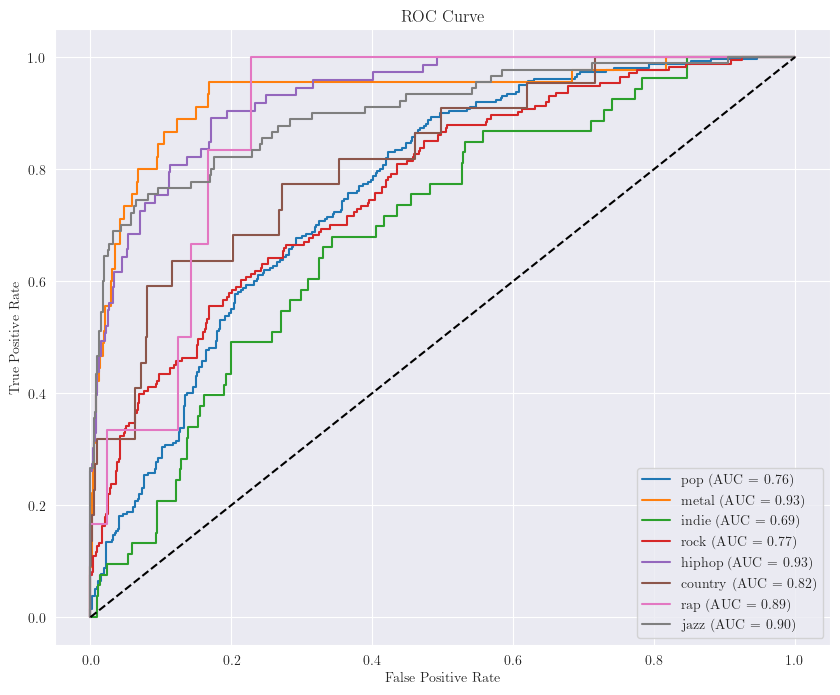

In [18]:
# Evaluate the model on the test set
best_params = {'learning_rate': 1.8529931417413163e-05, 'batch_size': 16, 'num_layers': 2}

test_model = ResNetLSTM(input_size=512*3, hidden_size=512, num_layers=best_params['num_layers'], num_classes=8).to(DEVICE)

test_model = test_model.to("mps")

# Load the model weights
test_model.load_state_dict(torch.load("models/resnet_lstm_model_v1_weighted.pth", weights_only=True))

# Create a DataLoader instance for the test set
# test_loader = DataLoader(test_dataset, batch_size=32)
criterion = nn.CrossEntropyLoss()
test_model.eval()

with torch.no_grad():
    correct, total = 0, 0
    all_labels, all_probs = [], []
    all_labels_per_class, all_probs_per_class = [], []
    test_progress = tqdm.tqdm(test_loader, desc="Testing", leave=False)

    for mel_spectrogram, label in test_progress:
        mel_spectrogram, label = mel_spectrogram.to("mps").float(), label.to("mps")
        output = test_model(mel_spectrogram.unsqueeze(1))
        probabilities = nn.Softmax(dim=1)(output).cpu().numpy()
        all_probs.append(probabilities)
        all_labels.append(label.cpu().numpy())
        all_labels_per_class.extend(label.cpu().numpy())
        all_probs_per_class.extend(output.cpu().numpy())
        _, predicted = torch.max(output.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

        # Calculate the loss
        loss = criterion(output, label)
        test_progress.set_postfix({"Loss": f"{loss.item():.4f}"})

    # Concatenate all predictions and true labels
    all_labels = np.concatenate(all_labels)
    all_probs = np.concatenate(all_probs)

    all_labels_per_class = np.array(all_labels_per_class)
    all_probs_per_class = np.array(all_probs_per_class)
    y_pred = all_probs_per_class.argmax(axis=1)

    # Per-class metrics
    print("PER CLASS METRICS")
    per_class_metrics(all_labels, y_pred, num_classes=8)

    # Calculate metrics
    metrics = calculate_metrics(all_labels, all_probs, num_classes=8)
    print("OVERALL METRICS")

    print(f"Accuracy: {100 * correct / total:.2f}% | Metrics: {metrics}")
# Plot the confusion matrix with annotations on test set
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, y_pred)

# Plot the confusion matrix with annotations
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, cmap="Blues")
plt.colorbar()
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(range(8), mel_dataset.genres, rotation=45)
plt.yticks(range(8), mel_dataset.genres)
for i in range(8):
    for j in range(8):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="black")
plt.show()
# Now plot the normalized confusion matrix
import seaborn as sns

# Normalize the confusion matrix
conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_norm, cmap="Blues", annot=True, fmt=".2f", xticklabels=mel_dataset.genres,
            yticklabels=mel_dataset.genres)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
# Plot ROC curve
from sklearn.metrics import roc_curve

# Get the true positive rate and false positive rate
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(8):
    fpr[i], tpr[i], _ = roc_curve((all_labels == i).astype(int), all_probs[:, i])
    roc_auc[i] = roc_auc_score((all_labels == i).astype(int), all_probs[:, i])

# Plot the ROC curve
plt.figure(figsize=(10, 8))
for i in range(8):
    plt.plot(fpr[i], tpr[i], label=f"{mel_dataset.genres[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
# Add legend
plt.legend()
plt.show()